![Pytorch](../../../pytorch_logo_2018.svg)

# Pytorch 中级篇（1）：卷积神经网络（Convolutional Neural Network）

>参考代码
>
>**yunjey的 [pytorch tutorial系列](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py)**

In [8]:
# 包
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [9]:
# 设备配置
torch.cuda.set_device(1) # 这句用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 超参数设置
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [10]:
print(device)

cuda


## MINIST数据集

In [11]:
# 训练数据集
train_dataset = torchvision.datasets.MNIST(root='../../../data/minist/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

# 测试数据集
test_dataset = torchvision.datasets.MNIST(root='../../../data/minist',
                                          train=False, 
                                          transform=transforms.ToTensor())

# 数据加载器
# 训练数据 加载器
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

# 测试数据加载器
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

## 自定义 卷积神经网络

>参考阅读
>
>卷积层的计算细节可以看这篇
>[CNN中卷积层的计算细节](https://zhuanlan.zhihu.com/p/29119239)
>
>更详细的介绍，包括池化层的，可以看这篇
>[卷积神经网络中的参数计算](https://www.cnblogs.com/hejunlin1992/p/7624807.html)

In [13]:
# 搭建卷积神经网络模型
# 两个卷积层
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            # 卷积层计算
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            #  批归一化
            nn.BatchNorm2d(16),
            #ReLU激活函数
            nn.ReLU(),
            # 池化层：最大池化
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    # 定义前向传播顺序
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [14]:
# 实例化一个模型，并迁移至gpu
model = ConvNet(num_classes).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 训练模型

In [15]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 注意模型在GPU中，数据也要搬到GPU中
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.1262
Epoch [1/5], Step [200/600], Loss: 0.1282
Epoch [1/5], Step [300/600], Loss: 0.0826
Epoch [1/5], Step [400/600], Loss: 0.0521
Epoch [1/5], Step [500/600], Loss: 0.0899
Epoch [1/5], Step [600/600], Loss: 0.0369
Epoch [2/5], Step [100/600], Loss: 0.0278
Epoch [2/5], Step [200/600], Loss: 0.0228
Epoch [2/5], Step [300/600], Loss: 0.0493
Epoch [2/5], Step [400/600], Loss: 0.0382
Epoch [2/5], Step [500/600], Loss: 0.0487
Epoch [2/5], Step [600/600], Loss: 0.0127
Epoch [3/5], Step [100/600], Loss: 0.0319
Epoch [3/5], Step [200/600], Loss: 0.0355
Epoch [3/5], Step [300/600], Loss: 0.0438
Epoch [3/5], Step [400/600], Loss: 0.0626
Epoch [3/5], Step [500/600], Loss: 0.0343
Epoch [3/5], Step [600/600], Loss: 0.0376
Epoch [4/5], Step [100/600], Loss: 0.0093
Epoch [4/5], Step [200/600], Loss: 0.0098
Epoch [4/5], Step [300/600], Loss: 0.0054
Epoch [4/5], Step [400/600], Loss: 0.0814
Epoch [4/5], Step [500/600], Loss: 0.0385
Epoch [4/5], Step [600/600], Loss:

## 测试并保存模型

In [16]:
# 切换成评估测试模式
# 这是因为在测试时，与训练时的dropout和batch normalization的操作是不同的
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [17]:
# 节省计算资源，不去计算梯度
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 98.75 %


In [18]:
#  保存模型
torch.save(model.state_dict(), 'model.ckpt')

# 如何用自己的图片和模型进行测试（单张）

In [39]:
#导入包
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

#resize功能
from scipy import misc

In [40]:
# 彩图转灰度
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

(225, 225, 3)


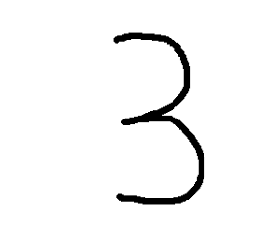

In [41]:
# 读取图像
srcPath = '3.png'
src = mpimg.imread(srcPath)# 读取和代码处于同一目录下的 图片
# 此时 lena 就已经是一个 np.array 了，可以对它进行任意处理
# 原图大小
print(src.shape) 

plt.imshow(src) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

(28, 28)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(-0.5, 27.5, 27.5, -0.5)

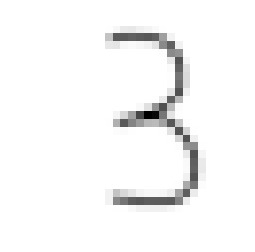

In [42]:
gray = rgb2gray(src)    #转灰度

gray_new_sz = misc.imresize(gray, (28,28) )# 第二个参数如果是整数，则为百分比，如果是tuple，则为输出图像的尺寸
print(gray_new_sz.shape)
plt.imshow(gray_new_sz, cmap='Greys_r')
plt.axis('off')

In [43]:
# 转换为（B,C,H,W）大小
image = gray_new_sz.reshape(-1,1,28,28)

# 转换为torch tensor
image_tensor = torch.from_numpy(image).float()

In [44]:
# 调用模型进行评估
# model.eval() 
output = model(image_tensor.to(device))
_, predicted = torch.max(output.data, 1)
pre = predicted.cpu().numpy()
print(pre) # 查看预测结果

[8]


# 友情Tip：查看Pytorch跑在哪块GPU上

遇到`cuda runtime error: out of memory`时，可以查看一下跑在哪块GPU上了。

然后用`nvidia-smi`看一下是不是GPU被占用了。

In [ ]:
# 这一段可以用来查看当前GPU的情况
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())